In [1]:
# !pip install -q -U tensorflow-text
# !pip install -q tf-models-official
# !pip install tensorflow_hub

# **Note:** 
It is not recommended to remove features like stopwords, numbers, repeating characters, Stem & Lemm, and punctuations for the BERT model. Removing these can be a bad idea for the BERT model because BERT is a pre-trained model and these features can give a negative impact on the accuracy. Because single punctuation or repeating characters or words also shows some emotions. You can always do experiments to check which features give what impact, it will vary based on the dataset.

In [2]:
# !pip uninstall tensorflow-text
# !pip install tensorflow-tex

In [3]:

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import wordcloud
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from keras import backend as K
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy


sns.set_style("whitegrid")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train = train.drop(['keyword','location'], axis = 1)
test = test.drop(['keyword','location'], axis = 1)
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


Check Shape

In [6]:
print("Shape of Train :", train.shape)
print("Shape of Test :", test.shape)

Shape of Train : (7613, 3)
Shape of Test : (3263, 2)


In [7]:
train_set = train.copy()
train_set['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# BERT 

In [8]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4")

In [9]:
# Bert layers:
num_classes = 2
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers:
l = tf.keras.layers.Dropout(0.2, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(l)

# Construct final model:
model = tf.keras.Model(inputs=[text_input], outputs=[l])
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

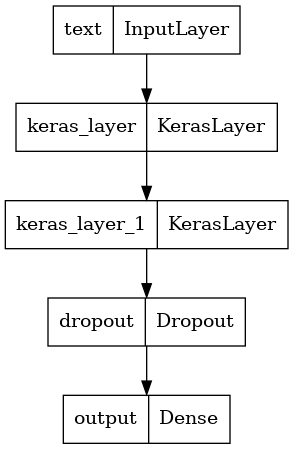

In [10]:
#Ploting Model Architecture:
tf.keras.utils.plot_model(model)

### Training model:

In [11]:
stop_word = stopwords.words('english')
train_set['text'] = train_set['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))

In [12]:
tokens = (word_tokenize(i) for i in train_set.text)
train_set['text'] = train_set['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def red_sequence(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def red_seq_tweet(tweet):
    return [red_sequence(word) for word in tweet]
train_set.text = train_set.text.apply(lambda tweet: red_seq_tweet(tweet))

def listToString(s): 
    str1 = " " 
    return (str1.join(s))
train_set['text'] = train_set['text'].apply(lambda x: listToString(x))

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

train_set['text'] = train_set['text'].apply(lambda x: cleaning_punctuations(x))

In [15]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

train_set['text'] = train_set['text'].apply(lambda text: cleaning_numbers(text))

In [16]:
# Tokenizing tweets:
tokens = (word_tokenize(i) for i in train_set.text)
train_set['text'] = train_set['text'].apply(nltk.word_tokenize)

stemm = SnowballStemmer('english')
train_set['text'] = train_set['text'].apply(lambda x: [stemm.stem(y) for y in x])

In [17]:
y = tf.keras.utils.to_categorical(train_set['target'].astype(str), num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(train_set['text'].astype(str), y, test_size=0.2, random_state=3)

In [18]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/30
172/172 [==============================] - 125s 615ms/step - loss: 0.7228 - accuracy: 0.5598 - val_loss: 0.6858 - val_accuracy: 0.5550
Epoch 2/30
172/172 [==============================] - 114s 665ms/step - loss: 0.6974 - accuracy: 0.5844 - val_loss: 0.6841 - val_accuracy: 0.5632
Epoch 3/30
172/172 [==============================] - 114s 666ms/step - loss: 0.6961 - accuracy: 0.5920 - val_loss: 0.6414 - val_accuracy: 0.6601
Epoch 4/30
172/172 [==============================] - 114s 665ms/step - loss: 0.6706 - accuracy: 0.6105 - val_loss: 0.6368 - val_accuracy: 0.6305
Epoch 5/30
172/172 [==============================] - 114s 666ms/step - loss: 0.6637 - accuracy: 0.6263 - val_loss: 0.6844 - val_accuracy: 0.5550
Epoch 6/30
172/172 [==============================] - 115s 667ms/step - loss: 0.6517 - accuracy: 0.6375 - val_loss: 0.6207 - val_accuracy: 0.6749
Epoch 7/30
172/172 [==============================] - 115s 667ms/step - loss: 0.6473 - accuracy: 0.6382 - val_loss: 0.6205 -

[0.5875425338745117, 0.70124751329422]

### Results:

In [19]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

48/48 [==============================] - 27s 536ms/step
Confusion Matrix
[[734 107]
 [348 334]]
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       841
           1       0.76      0.49      0.59       682

    accuracy                           0.70      1523
   macro avg       0.72      0.68      0.68      1523
weighted avg       0.71      0.70      0.69      1523



### Accuracy vs Loss:

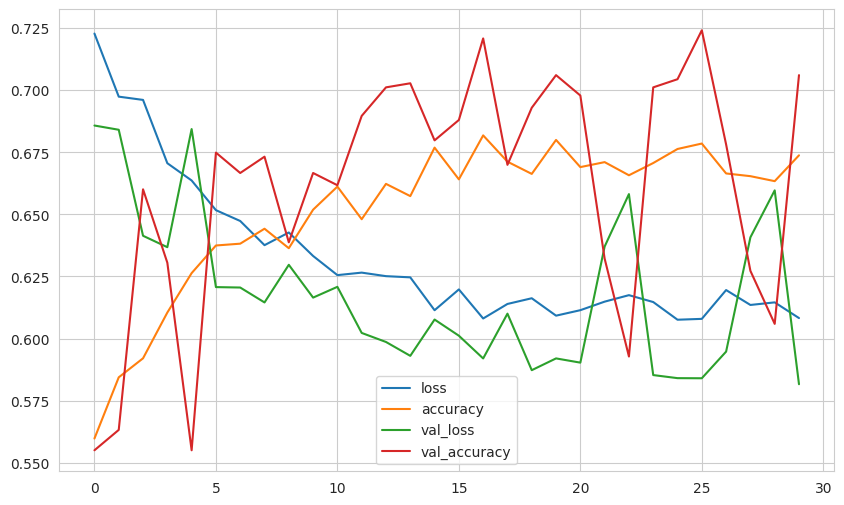

In [20]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()